In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from datasets import load_dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix, binary_f1_score
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd
from huggingface_hub import notebook_login
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict, deque
from sklearn.model_selection import train_test_split
import random
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")

import re
from typing import List, Dict
    
from src.preprocessing.sequence_classification.dataset import get_n_shots_per_class, get_dataloader
from src.preprocessing.sequence_classification.set_fit_dataset import SetFitDataset
from src.model.sequence_classification.setfit_trainer import SetFitTrainer
from src.model.sequence_classification.trainer import SequenceClassificationTrainer
import warnings
warnings.filterwarnings("ignore")

In [3]:
!mkdir logs
model_name = "SetFit"
dataset_name = "SST5"
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
# logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)

mkdir: cannot create directory ‘logs’: File exists


In [4]:
# model = SentenceTransformer("whaleloops/phrase-bert")

In [5]:
try:
    from torch.hub import _get_torch_home

    torch_cache_home = _get_torch_home()
except ImportError:
    torch_cache_home = os.path.expanduser(os.getenv('TORCH_HOME', os.path.join(os.getenv('XDG_CACHE_HOME', '~/.cache'), 'torch')))

cache_folder = os.path.join(torch_cache_home, 'sentence_transformers')

In [6]:
cache_folder

'/users/eleves-a/2022/pedro.silva/.cache/torch/sentence_transformers'

## Loading SST5 data

In [4]:
sst5_dataset = load_dataset("SetFit/sst5")

Repo card metadata block was not found. Setting CardData to empty.


In [5]:
classes = np.unique(sst5_dataset['train']['label'], return_counts=True)
classes

(array([0, 1, 2, 3, 4]), array([1092, 2218, 1624, 2322, 1288]))

In [6]:
num_classes = len(classes[0])

In [7]:
num_classes

5

In [8]:
data_size = len(sst5_dataset['train'])
data_size

8544

In [9]:
train_text = sst5_dataset['train']['text'][0:data_size*3//5]
train_labels = sst5_dataset['train']['label'][0:data_size*3//5]

val_text = sst5_dataset['train']['text'][data_size*3//5:]
val_labels = sst5_dataset['train']['label'][data_size*3//5:]

## Normal Finetune

In [14]:
bert = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = num_classes)\
    .to(device)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
train_dataloader = get_dataloader(
    train_text,
    train_labels,
    tokenizer,
    n_shots = 200,
    num_classes= num_classes,
    equalize_class=False,
    batch_size = 8
)

val_dataloader = get_dataloader(
    val_text,
    val_labels,
    tokenizer,
    n_shots = 100,
    equalize_class=False,
    num_classes=num_classes
)

In [16]:
train_dataloader.dataset[0:]

{'input_ids': tensor([[  101,  1037, 18385,  ...,     0,     0,     0],
         [  101,  4593,  2128,  ...,     0,     0,     0],
         [  101,  2027,  3653,  ...,     0,     0,     0],
         ...,
         [  101,  1998,  2111,  ...,     0,     0,     0],
         [  101,  1996,  4616,  ...,     0,     0,     0],
         [  101,  1012,  1012,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([4, 1, 1, 2, 3, 2, 3, 3, 1, 4, 1, 1, 3, 1, 1, 4, 3, 3, 1, 4, 0, 1, 1, 4,
         1, 2, 1, 2, 0, 3, 4, 1, 4, 1, 2, 1, 2, 2, 3, 2, 3, 3, 2, 2, 3, 1, 2, 2,
         2, 2, 1, 1, 4, 3, 3, 2, 3, 3, 1, 4, 0, 3, 3, 3, 4, 1, 2, 3, 4, 4, 2, 0,
         3, 0, 3, 2, 4, 2, 3, 4, 3, 3, 3, 4, 1, 0, 0, 2, 4, 3, 1, 4, 3, 3, 4, 2,
         4, 3, 1, 1, 2, 1, 1, 4, 1, 1, 

In [17]:
np.unique(
    train_dataloader.dataset[0:]['labels'],
    return_counts= True

)

(array([0, 1, 2, 3, 4]), array([132, 261, 174, 279, 154]))

In [19]:
histories = {}

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

for i in range(6):

    bert = AutoModelForSequenceClassification\
        .from_pretrained("bert-base-uncased", num_labels = num_classes)\
        .to(device)

    trainer = SequenceClassificationTrainer(
        bert,
        num_classes
    )
    n_shots = 100//2**i
    
    train_dataloader = get_dataloader(
        train_text,
        train_labels,
        tokenizer,
        n_shots= n_shots,
        num_classes= num_classes,
        shuffle = True,
        worker_init_fn=seed_worker,
        generator=g
    )

    val_dataloader = get_dataloader(
        val_text,
        val_labels,
        tokenizer,
        n_shots = 250,
        num_classes=num_classes,
        equalize_class=False
    )

    history = trainer.compile(
        train_dataloader,
        val_dataloader,
        n_epochs=10
    )

    histories[100//2**i] = history

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 500/500 [00:22<00:00, 22.15it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 250/250 [00:11<00:00, 22.17it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 125/

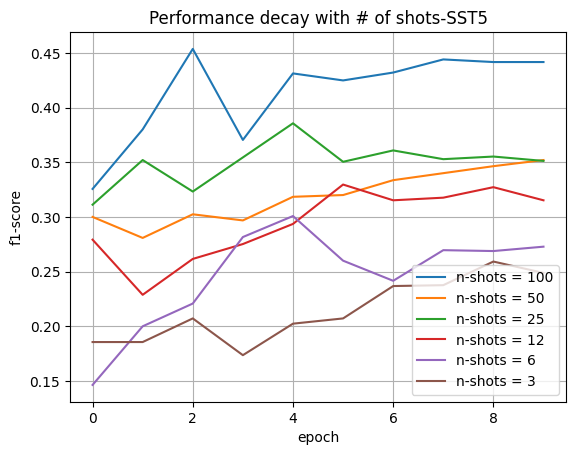

In [20]:
results = {}
for k, v in histories.items():
    plt.plot(v['val_f1'],
             label = f"n-shots = {k}")
    
plt.title("Performance decay with # of shots-SST5")
    
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("f1-score")
plt.show()

## SetFit

In [34]:
X_train, y_train = get_n_shots_per_class(
    train_text,
    train_labels,
    n_shots= 8,
    num_classes= num_classes
)

In [35]:
X_val, y_val = get_n_shots_per_class(
    val_text, 
    val_labels,
    n_shots = 6,
    num_classes=num_classes
)

In [36]:
set_fit_data_train = SetFitDataset(
    X_train,
    y_train, 
    input_example_format= True
    # R = 5
)

set_fit_data_val = SetFitDataset(
    X_val,
    y_val,
    # R = 5,
    input_example_format= False
)

In [37]:
train_dataloader = DataLoader(
    set_fit_data_train.data,
    shuffle=True
)

val_dataloader = DataLoader(
    set_fit_data_val
)

In [73]:
class CLF(torch.nn.Module):
    def __init__(
        self,
        in_features : int,
        out_features : int, 
        activation_fn : callable = torch.nn.ReLU(),
        *args, 
        **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)

        self.layer1 = torch.nn.Linear(in_features, 512)
        self.activation = activation_fn
        self.layer2 = torch.nn.Linear(512, 256)
        self.layer3 = torch.nn.Linear(256, out_features)

    def forward(self, x : torch.Tensor):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        x = self.activation(x)
        x= self.layer3(x)
        return x
    

In [58]:
embedding_model = SentenceTransformer("sentence-transformers/all-roberta-large-v1")
clf = CLF(embedding_model.get_sentence_embedding_dimension(),
          num_classes)
setfit_trainer = SetFitTrainer(
    embedding_model,
    clf,
    "sst5",
    num_classes
)

In [59]:
setfit_trainer.train_embedding(
    train_dataloader,
    val_dataloader,
    n_shots=8,
    show_progress_bar = True,
    n_epochs=20
)


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/780 [00:00<?, ?it/s]

Running validation after 0 epochs


100%|██████████| 435/435 [00:06<00:00, 64.98it/s]

f1 score: 0.0
tensor([[360,   0],
        [ 75,   0]], device='cuda:0')


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/780 [00:00<?, ?it/s]

Running validation after 1 epochs


100%|██████████| 435/435 [00:06<00:00, 64.63it/s]

f1 score: 0.0
tensor([[360,   0],
        [ 75,   0]], device='cuda:0')


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/780 [00:00<?, ?it/s]

Running validation after 2 epochs


100%|██████████| 435/435 [00:06<00:00, 64.56it/s]

f1 score: 0.0
tensor([[360,   0],
        [ 75,   0]], device='cuda:0')


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/780 [00:00<?, ?it/s]

Running validation after 3 epochs


100%|██████████| 435/435 [00:06<00:00, 63.50it/s]

f1 score: 0.0
tensor([[360,   0],
        [ 75,   0]], device='cuda:0')


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/780 [00:00<?, ?it/s]

Running validation after 4 epochs


100%|██████████| 435/435 [00:06<00:00, 63.50it/s]

f1 score: 0.0
tensor([[359,   1],
        [ 75,   0]], device='cuda:0')


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/780 [00:00<?, ?it/s]

Running validation after 5 epochs


100%|██████████| 435/435 [00:06<00:00, 64.32it/s]


f1 score: 0.04878048598766327
tensor([[355,   5],
        [ 73,   2]], device='cuda:0')


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/780 [00:00<?, ?it/s]

Running validation after 6 epochs


100%|██████████| 435/435 [00:06<00:00, 64.41it/s]


f1 score: 0.21052631735801697
tensor([[333,  27],
        [ 63,  12]], device='cuda:0')


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/780 [00:00<?, ?it/s]

Running validation after 7 epochs


100%|██████████| 435/435 [00:06<00:00, 63.39it/s]

f1 score: 0.2682926654815674
tensor([[293,  67],
        [ 53,  22]], device='cuda:0')


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/780 [00:00<?, ?it/s]

Running validation after 8 epochs


100%|██████████| 435/435 [00:06<00:00, 63.16it/s]


f1 score: 0.30434781312942505
tensor([[279,  81],
        [ 47,  28]], device='cuda:0')


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/780 [00:00<?, ?it/s]

Running validation after 9 epochs


100%|██████████| 435/435 [00:06<00:00, 64.37it/s]

f1 score: 0.3236994445323944
tensor([[290,  70],
        [ 47,  28]], device='cuda:0')


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/780 [00:00<?, ?it/s]

Running validation after 10 epochs


100%|██████████| 435/435 [00:06<00:00, 64.97it/s]


f1 score: 0.32768362760543823
tensor([[287,  73],
        [ 46,  29]], device='cuda:0')


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/780 [00:00<?, ?it/s]

Running validation after 11 epochs


100%|██████████| 435/435 [00:06<00:00, 64.69it/s]

f1 score: 0.2906976640224457
tensor([[288,  72],
        [ 50,  25]], device='cuda:0')


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/780 [00:00<?, ?it/s]

Running validation after 12 epochs


100%|██████████| 435/435 [00:07<00:00, 59.15it/s]

f1 score: 0.3212434947490692
tensor([[273,  87],
        [ 44,  31]], device='cuda:0')


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/780 [00:00<?, ?it/s]

Running validation after 13 epochs


100%|██████████| 435/435 [00:06<00:00, 64.67it/s]

f1 score: 0.28248587250709534
tensor([[283,  77],
        [ 50,  25]], device='cuda:0')


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/780 [00:00<?, ?it/s]

Running validation after 14 epochs


100%|██████████| 435/435 [00:06<00:00, 63.74it/s]


f1 score: 0.2857142686843872
tensor([[291,  69],
        [ 51,  24]], device='cuda:0')


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/780 [00:00<?, ?it/s]

Running validation after 15 epochs


100%|██████████| 435/435 [00:06<00:00, 66.32it/s]

f1 score: 0.2958579957485199
tensor([[291,  69],
        [ 50,  25]], device='cuda:0')


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/780 [00:00<?, ?it/s]

Running validation after 16 epochs


100%|██████████| 435/435 [00:06<00:00, 66.35it/s]

f1 score: 0.277777761220932
tensor([[280,  80],
        [ 50,  25]], device='cuda:0')


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/780 [00:00<?, ?it/s]

Running validation after 17 epochs


100%|██████████| 435/435 [00:06<00:00, 66.38it/s]

f1 score: 0.2921348214149475
tensor([[283,  77],
        [ 49,  26]], device='cuda:0')


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/780 [00:00<?, ?it/s]

Running validation after 18 epochs


100%|██████████| 435/435 [00:06<00:00, 66.36it/s]

f1 score: 0.32222220301628113
tensor([[284,  76],
        [ 46,  29]], device='cuda:0')


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/780 [00:00<?, ?it/s]

Running validation after 19 epochs


100%|██████████| 435/435 [00:06<00:00, 66.37it/s]


f1 score: 0.2696629464626312
tensor([[281,  79],
        [ 51,  24]], device='cuda:0')


HfHubHTTPError: 409 Client Error: Conflict for url: https://huggingface.co/api/repos/create (Request ID: Root=1-6578935d-076e285f586daa0f6f65e646;9244725e-6f07-4ec6-b6fe-d10b1f8a9ec8)

You already created this model repo

In [62]:
setfit_trainer.best_model.save_to_hub("peulsilva/roberta-large-setfit-8shots-sst5")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Cloning https://huggingface.

Upload file model.safetensors:   0%|          | 1.00/1.32G [00:00<?, ?B/s]

To https://huggingface.co/peulsilva/roberta-large-setfit-8shots-sst5
   7a12be6..be250ea  main -> main

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'https://huggingface.co/peulsilva/roberta-large-setfit-8shots-sst5/commit/be250ea554b37bcb563ad836bb0f00f98bb4d4cb'

In [63]:
X_train, y_train = get_n_shots_per_class(
    train_text,
    train_labels,
    n_shots= 8,
    num_classes= num_classes
)

X_val, y_val = get_n_shots_per_class(
    val_text, 
    val_labels,
    n_shots = 100,
    num_classes=num_classes,
)

from random import shuffle
def shuffle_two_lists(X, y ):
    X_shuff = []
    y_shuff = []
    index_shuf = list(range(len(X)))
    shuffle(index_shuf)
    for i in index_shuf:
        X_shuff.append(X[i])
        y_shuff.append(y[i])


    return X_shuff, y_shuff
X_train_shuffled , y_train_shuffled = shuffle_two_lists(X_train, y_train)

In [74]:
setfit_trainer.classifier_model = CLF(
    embedding_model.get_sentence_embedding_dimension(),
    num_classes,
    activation_fn= torch.nn.ReLU()
)
setfit_trainer.classifier_model.to(device)
setfit_trainer.train_classifier(
    X_train_shuffled,
    y_train_shuffled,
    X_val,
    y_val ,
    n_epochs=50   
)

---------Epoch: 49-----------
f1 score: 0.36399999260902405
tensor([[65, 19, 14,  2,  0],
        [45, 19, 19, 10,  7],
        [18, 27, 27, 19,  9],
        [ 6, 13, 26, 30, 25],
        [ 1, 16, 13, 29, 41]], device='cuda:0')


[0.20000001788139343,
 0.20000001788139343,
 0.20400001108646393,
 0.22200000286102295,
 0.22599999606609344,
 0.23600000143051147,
 0.30000001192092896,
 0.31200000643730164,
 0.33399999141693115,
 0.35199999809265137,
 0.34599998593330383,
 0.3499999940395355,
 0.35199999809265137,
 0.35600000619888306,
 0.35600000619888306,
 0.3659999966621399,
 0.3659999966621399,
 0.36800000071525574,
 0.3779999613761902,
 0.37400001287460327,
 0.3700000047683716,
 0.36399999260902405,
 0.3619999587535858,
 0.3619999587535858,
 0.35999998450279236,
 0.35999998450279236,
 0.3619999587535858,
 0.3619999587535858,
 0.36399999260902405,
 0.3580000102519989,
 0.35999998450279236,
 0.3619999587535858,
 0.35999998450279236,
 0.35999998450279236,
 0.3619999587535858,
 0.35999998450279236,
 0.35999998450279236,
 0.35999998450279236,
 0.35999998450279236,
 0.3619999587535858,
 0.3619999587535858,
 0.3619999587535858,
 0.3619999587535858,
 0.3619999587535858,
 0.3619999587535858,
 0.3619999587535858,
 0.3619

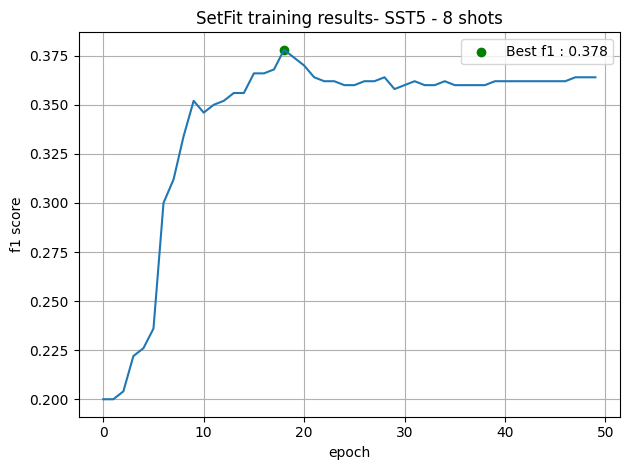

In [75]:
history = setfit_trainer.history
best_f1, best_epoch = np.max(history), np.argmax(history)
plt.plot(setfit_trainer.history)

plt.grid()
plt.scatter(
    [best_epoch],
        [best_f1],
    color = "green",
    label = f"Best f1 : {round(best_f1,3)}"
)
plt.legend()
plt.ylabel("f1 score")
plt.xlabel("epoch")
plt.title("SetFit training results- SST5 - 8 shots")
plt.tight_layout()